# Setup model

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import keras

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomTranslation

import matplotlib.pyplot as plt

%matplotlib inline


seed = 450
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")
BATCH_SIZE = 64

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


# Load model and augmentation

In [ ]:
training_data = np.load("/kaggle/input/datasetlomi/training_set_no_outliers.npz")
test_data = np.load("/kaggle/input/datasetlomi/test_set.npz")
images = training_data["images"]/255
labels = training_data["labels"]
print(images.shape)

(2270, 64, 128)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2)

In [ ]:
def add_channel(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)
    return image, label

In [ ]:
"Flip Left Right"
@tf.function
def random_flip_left_right(image, label, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.8,
        lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
        lambda: (image, label)
    )

    return image, label

In [ ]:
"Flip Up Down"
@tf.function
def random_flip_up_down(image, label, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.8,
        lambda: (tf.image.flip_up_down(image), tf.image.flip_up_down(label)),
        lambda: (image, label)
    )

    return image, label

In [ ]:
"Translation"
@tf.function
def translation(image, label, max_translation=0.2, seed=None):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    max_dx = tf.cast(max_translation * tf.cast(width, tf.float32), tf.int32)
    max_dy = tf.cast(max_translation * tf.cast(height, tf.float32), tf.int32)

    dx = tf.random.uniform([], -max_dx, max_dx + 1, dtype=tf.int32, seed=seed)
    dy = tf.random.uniform([], -max_dy, max_dy + 1, dtype=tf.int32, seed=seed)

    translated_image = tf.roll(image, shift=[dy, dx], axis=[0, 1])
    translated_label = tf.roll(label, shift=[dy, dx], axis=[0, 1])

    return translated_image, translated_label


@tf.function
def random_translation(image, label, max_translation=0.2, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.8,
        lambda: (translation(image,label)),
        lambda: (image, label)
    )
    return image, label

In [ ]:
"Black Square"
@tf.function
def zero_square(image, label, max_square_ratio=0.2, seed=None):
    # Calcola altezza e larghezza dell'immagine
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Determina la dimensione massima del quadrato
    max_square_size = tf.cast(max_square_ratio * tf.minimum(tf.cast(height, tf.float32),
                                                            tf.cast(width, tf.float32)), tf.int32)

    # Assicurati che il quadrato abbia senso nelle dimensioni dell'immagine
    max_square_size = tf.maximum(1, tf.minimum(max_square_size, tf.minimum(height, width)))

    # Genera la dimensione del quadrato
    square_size = tf.random.uniform([], 1, max_square_size + 1, dtype=tf.int32, seed=seed)

    # Genera la posizione del quadrato
    max_x = tf.maximum(0, width - square_size)
    max_y = tf.maximum(0, height - square_size)

    start_x = tf.random.uniform([], 0, max_x + 1, dtype=tf.int32, seed=seed)
    start_y = tf.random.uniform([], 0, max_y + 1, dtype=tf.int32, seed=seed)

    # Crea una maschera per "cancellare" il quadrato
    mask = tf.ones_like(image)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(tf.meshgrid(
            tf.range(start_y, start_y + square_size),
            tf.range(start_x, start_x + square_size)
        ), axis=-1),
        updates=tf.zeros([square_size, square_size, tf.shape(image)[-1]], dtype=image.dtype)
    )

    # Applica la maschera a immagine e label
    zeroed_image = image * mask
    zeroed_label = label * mask

    return zeroed_image, zeroed_label



@tf.function
def random_zero_square(image, label, max_square_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.8,
        lambda: zero_square(image, label, max_square_ratio, seed),
        lambda: (image, label)
    )

    return image, label

In [ ]:
"random_negative"
@tf.function
def random_negative(image, label, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.8,
        lambda: (1-image, label),
        lambda: (image, label)
    )

    return image, label

In [ ]:
def duplicate_dataset(images, labels, quantity = 1):
        images = np.concatenate([images, images[:quantity]], axis=0)
        labels = np.concatenate([labels, labels[:quantity]], axis=0)
        return (images, labels)

In [ ]:
def to_datasett(X_train, y_train, augmentation = False, seed = seed, shuffle = True, batch_size = BATCH_SIZE, duplicate = False):
    if duplicate:
        X_train, y_train = duplicate_dataset(X_train, y_train, len(X_train))
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    dataset = dataset.map(
                    lambda x, y: add_channel(x, y),
                    num_parallel_calls=tf.data.AUTOTUNE
                   )

    if augmentation:
        dataset = dataset.map(
                        lambda x, y: random_flip_up_down(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
        dataset = dataset.map(
                        lambda x, y: random_flip_left_right(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
        dataset = dataset.map(
                        lambda x, y: random_translation(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
        dataset = dataset.map(
                        lambda x, y: random_negative(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
        dataset = dataset.map(
                        lambda x, y: random_zero_square(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
            # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset_original = to_datasett(X_train, y_train, augmentation=False)
train_dataset_aug = to_datasett(X_train, y_train, augmentation = True)
final_dataset = train_dataset_original.concatenate(train_dataset_aug)

val_dataset = to_datasett(X_val, y_val, augmentation = False)

# Model

In [ ]:
num_classes = 5
epoch = 1000
patience = 40

In [ ]:
def efficient_skip_connection(skip_tensor, target_channels, name):
    """
    Ottimizza una connessione skip riducendo il numero di canali tramite una convoluzione 1x1.
    - Riduce i canali mantenendo la struttura spaziale.
    """
    x = tfkl.Conv2D(target_channels, kernel_size=1, padding='same', activation='relu', name=name + '_conv1x1')(skip_tensor)
    return x

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    """
    Applica una sequenza di convoluzioni seguite da Batch Normalization e attivazione.
    """
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=f"{name}_conv{i+1}")(x)
        x = tfkl.BatchNormalization(name=f"{name}_bn{i+1}")(x)
        x = tfkl.Activation(activation, name=f"{name}_activation{i+1}")(x)
    return x


In [ ]:
def unetpp_block(inputs, filters, name):
    """
    Crea un nodo della U-Net++ che combina input provenienti da diversi livelli.
    """
    if len(inputs) > 1:
        x = tfkl.Concatenate(name=f"{name}_concat")(inputs)
    else:
        x = inputs[0]

    # Primo blocco convoluzionale con LeakyReLU
    x = tfkl.Conv2D(filters, kernel_size=3, padding="same", name=f"{name}_conv1")(x)
    x = tfkl.BatchNormalization(name=f"{name}_bn1")(x)
    x = tfkl.LeakyReLU(negative_slope=0.1, name=f"{name}_leakyrelu1")(x)  # Sostituito alpha con negative_slope

    # Secondo blocco convoluzionale con LeakyReLU
    x = tfkl.Conv2D(filters, kernel_size=3, padding="same", name=f"{name}_conv2")(x)
    x = tfkl.BatchNormalization(name=f"{name}_bn2")(x)
    x = tfkl.LeakyReLU(negative_slope=0.1, name=f"{name}_leakyrelu2")(x)  # Sostituito alpha con negative_slope

    return x


In [ ]:
def get_unetpp(input_shape=(64, 128,1), num_classes=5, filters=[32, 64, 128, 256, 512], seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Downsampling path
    x00 = unetpp_block([input_layer], filters[0], name="x00")
    d0 = tfkl.MaxPooling2D(pool_size=(2, 2))(x00)

    x10 = unetpp_block([d0], filters[1], name="x10")
    d1 = tfkl.MaxPooling2D(pool_size=(2, 2))(x10)

    x20 = unetpp_block([d1], filters[2], name="x20")
    d2 = tfkl.MaxPooling2D(pool_size=(2, 2))(x20)

    x30 = unetpp_block([d2], filters[3], name="x30")
    d3 = tfkl.MaxPooling2D(pool_size=(2, 2))(x30)

    x40 = unetpp_block([d3], filters[4], name="x40")

    # Upsampling path with dense connections
    x01 = unetpp_block([x00, tfkl.UpSampling2D(size=(2, 2))(x10)], filters[0], name="x01")
    x11 = unetpp_block([x10, tfkl.UpSampling2D(size=(2, 2))(x20)], filters[1], name="x11")
    x02 = unetpp_block([x01, tfkl.UpSampling2D(size=(2, 2))(x11)], filters[0], name="x02")

    x21 = unetpp_block([x20, tfkl.UpSampling2D(size=(2, 2))(x30)], filters[2], name="x21")
    x12 = unetpp_block([x11, tfkl.UpSampling2D(size=(2, 2))(x21)], filters[1], name="x12")
    x03 = unetpp_block([x02, tfkl.UpSampling2D(size=(2, 2))(x12)], filters[0], name="x03")

    x31 = unetpp_block([x30, tfkl.UpSampling2D(size=(2, 2))(x40)], filters[3], name="x31")
    x22 = unetpp_block([x21, tfkl.UpSampling2D(size=(2, 2))(x31)], filters[2], name="x22")
    x13 = unetpp_block([x12, tfkl.UpSampling2D(size=(2, 2))(x22)], filters[1], name="x13")
    x04 = unetpp_block([x03, tfkl.UpSampling2D(size=(2, 2))(x13)], filters[0], name="x04")

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax", name="output_layer")(x04)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name="UNetPlusPlus")
    return model

In [ ]:
model = get_unetpp()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
#model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

# Mean intersection over union

In [ ]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=[0], name="mean_iou", dtype=None, **kwargs):
        """
        Aggiunto **kwargs per gestire parametri inattesi come `ignore_class`.
        """
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        return super().update_state(y_true, y_pred, sample_weight)

# Registra la classe personalizzata
tf.keras.utils.get_custom_objects()["MeanIntersectionOverUnion"] = MeanIntersectionOverUnion


# Visualization

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [ ]:
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, frequency=5, num_classes=2):
        super().__init__()
        self.dataset = dataset
        self.frequency = frequency
        self.num_classes = num_classes
        self.dataset_iter = iter(dataset)  # Crea un iteratore per accedere ai dati

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epochs
            try:
                # Estrai un batch di dati
                image, label = next(self.dataset_iter)
            except StopIteration:
                # Ricrea l'iteratore se i dati sono terminati
                self.dataset_iter = iter(self.dataset)
                image, label = next(self.dataset_iter)

            # Prepara i dati per la predizione
            image = tf.expand_dims(image[0], 0)  # Estrai una sola immagine dal batch
            label = label[0]  # Etichetta corrispondente
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Creazione della mappa colori
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Immagine di input
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predizione
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()



# Losses

In [ ]:
labels_flat = y_train.reshape(-1)  # Appiattisci l'array per considerare tutti i pixel

# Conta la frequenza di ogni classe
num_classes = 5  # Modifica in base al numero di classi nel tuo dataset
labels_flat = labels_flat.astype(int)  # Converte i dati in interi

# Conta la frequenza di ogni classe
class_frequencies = np.bincount(labels_flat, minlength=num_classes)

# Stampa le frequenze
print(f"Frequenze delle classi: {class_frequencies}")

total_samples = np.sum(class_frequencies)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)
print(f"Pesi di classe: {class_weights}")

# Conversione in dizionario per TensorFlow
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Funzione di perdita con pesi di classe
loss = tf.keras.losses.SparseCategoricalCrossentropy()


def weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)  # Assicurati che i valori siano interi
    weights = tf.gather(class_weights, y_true)  # Recupera i pesi in base alle etichette
    weights = tf.cast(weights, tf.float32)  # Converte i pesi in float32
    unweighted_loss = loss(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)

Frequenze delle classi: [3932419 4109908 3775163 3041526   17656]
Pesi di classe: [  0.75661683   0.72394185   0.78813402   0.97823737 168.51690077]


In [ ]:
# La formula del dice score è la seguente: 2*intersection / (union+ intersection)
# Funzione per calcolare il Dice Score
# semplicemente viene creato il calcolo detto sopra
def dice_score(y_true, y_pred, smooth=1e-6):
    #smooth=1e-6 è un piccolo valore aggiunto per evitare la divisione per zero
    #nel caso in cui l'intersezione o l'unione siano zero (ad esempio, se una maschera è vuota).
    # Appiattiamo le immagini (in caso di batch)
    # Rimuovi la dimensione del canale su y_true (se necessario)
    y_true = tf.squeeze(y_true, axis=-1)

    # Converti y_pred in etichette di classe (argmax per ottenere la classe predetta)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)  # Assicurati che y_pred sia float32

    # Calcolo dell'intersezione e della somma
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    # Calcolo del Dice Score
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

In [ ]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result


In [ ]:
import tensorflow as tf

#@tfk.saving.register_keras_serializable(package='custom', name='CombinedLoss')
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, dice_weight=1.0, ce_weight=1.0, name="combined_loss", **kwargs):
        # Accetta anche il parametro name
        super(CombinedLoss, self).__init__(name=name, **kwargs)  # Passa 'name' al costruttore base
        self.dice_loss = DiceLoss()
        self.ce_loss = weighted_loss
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight

    def call(self, y_true, y_pred):
        dice = self.dice_loss(y_true, y_pred)  # Calcola Dice Loss
        ce = self.ce_loss(y_true, y_pred)  # Calcola Weighted Cross-Entropy Loss
        # Combinazione ponderata
        return self.dice_weight * dice + self.ce_weight * ce

    def get_config(self):
        # Restituisce la configurazione per serializzare la tua Loss
        config = super(CombinedLoss, self).get_config()
        config.update({
            'dice_weight': self.dice_weight,
            'ce_weight': self.ce_weight
        })
        return config


# Compilation and training

In [ ]:
model.compile(
    loss=CombinedLoss(dice_weight=0.5, ce_weight=1.0),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
    metrics=["accuracy" ,MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
#model.compile(optimizer='adam', loss=CombinedLoss(dice_weight=1.0, ce_weight=1.0), metrics=['accuracy'])


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

viz_callback = VizCallback(val_dataset, frequency=5, num_classes=5)

Epoch 1/1000


I0000 00:00:1733127579.621569      97 service.cc:145] XLA service 0x7c752c0042c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733127579.621648      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1733127586.441846      97 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/58 ━━━━━━━━━━━━━━━━━━━━ 42:11 44s/step - accuracy: 0.2134 - loss: 1.5542 - mean_iou: 0.1003

I0000 00:00:1733127605.139618      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/58 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.4124 - loss: 1.4869 - mean_iou: 0.2107

W0000 00:00:1733127612.961882      99 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


29/58 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - accuracy: 0.4149 - loss: 1.4828 - mean_iou: 0.2119

I0000 00:00:1733127625.409014      99 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_14', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_18', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_31', 16 bytes spill stores, 16 bytes spill loads



58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4502 - loss: 1.4197 - mean_iou: 0.2267

W0000 00:00:1733127637.181272      96 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733127640.030517      96 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


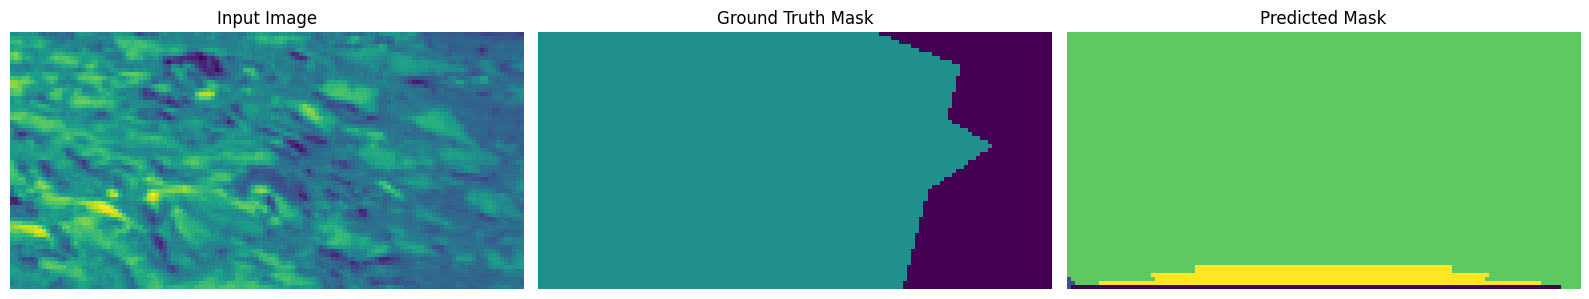

58/58 ━━━━━━━━━━━━━━━━━━━━ 84s 697ms/step - accuracy: 0.4509 - loss: 1.4182 - mean_iou: 0.2269 - val_accuracy: 0.1886 - val_loss: 36.2491 - val_mean_iou: 0.0544
Epoch 2/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.5675 - loss: 1.1932 - mean_iou: 0.2946 - val_accuracy: 0.1961 - val_loss: 18.4528 - val_mean_iou: 0.0685
Epoch 3/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.5782 - loss: 1.1399 - mean_iou: 0.3036 - val_accuracy: 0.1961 - val_loss: 17.7166 - val_mean_iou: 0.0548
Epoch 4/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.6221 - loss: 1.0564 - mean_iou: 0.3402 - val_accuracy: 0.1961 - val_loss: 11.8916 - val_mean_iou: 0.0685
Epoch 5/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.6353 - loss: 1.0294 - mean_iou: 0.3501 - val_accuracy: 0.1961 - val_loss: 14.7889 - val_mean_iou: 0.0548
Epoch 6/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6587 - loss: 0.9987 - mean_iou: 0.3680

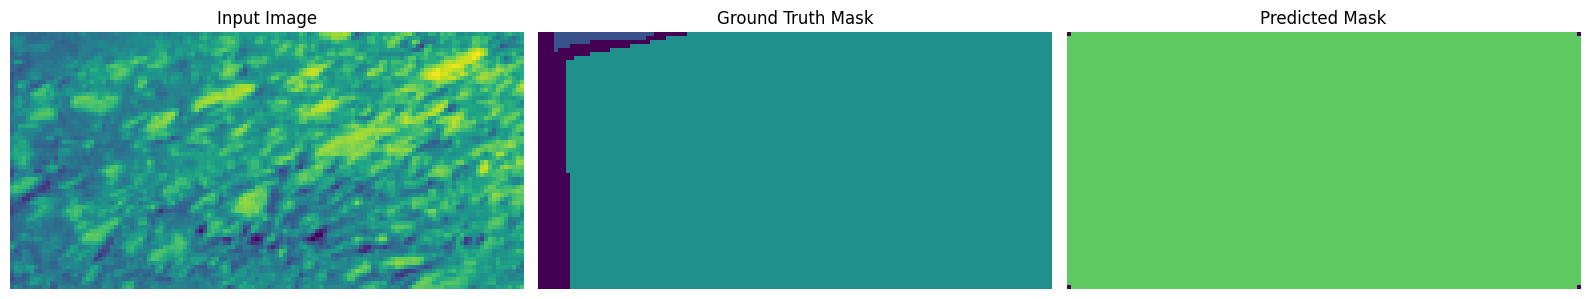

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.6586 - loss: 0.9987 - mean_iou: 0.3680 - val_accuracy: 0.1962 - val_loss: 10.1329 - val_mean_iou: 0.0548
Epoch 7/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.6697 - loss: 0.9714 - mean_iou: 0.3758 - val_accuracy: 0.2008 - val_loss: 9.1321 - val_mean_iou: 0.0586
Epoch 8/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.6859 - loss: 0.9450 - mean_iou: 0.3999 - val_accuracy: 0.2657 - val_loss: 4.4980 - val_mean_iou: 0.1086
Epoch 9/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.6859 - loss: 0.9399 - mean_iou: 0.3983 - val_accuracy: 0.3207 - val_loss: 4.0328 - val_mean_iou: 0.0897
Epoch 10/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.6768 - loss: 0.9353 - mean_iou: 0.3890 - val_accuracy: 0.4634 - val_loss: 2.5253 - val_mean_iou: 0.2596
Epoch 11/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7003 - loss: 0.9136 - mean_iou: 0.4086

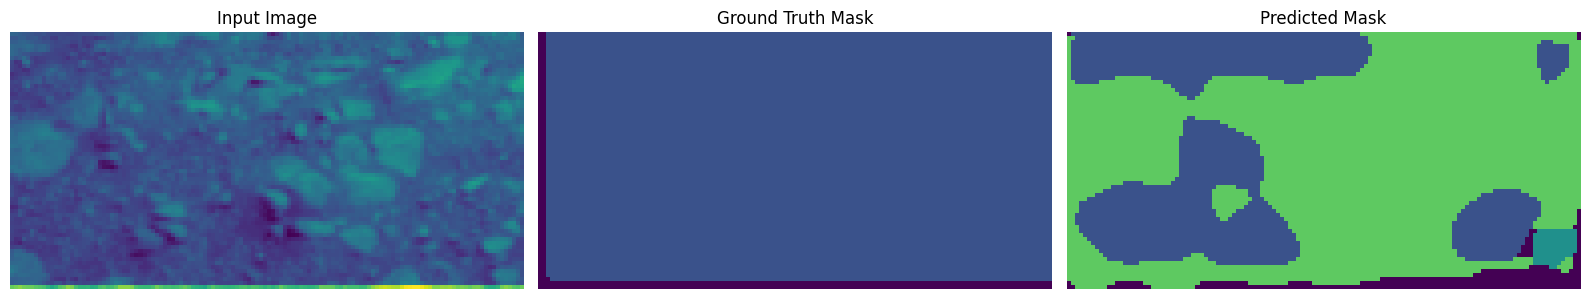

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.7002 - loss: 0.9136 - mean_iou: 0.4086 - val_accuracy: 0.5059 - val_loss: 2.0720 - val_mean_iou: 0.2506
Epoch 12/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.6947 - loss: 0.9010 - mean_iou: 0.4036 - val_accuracy: 0.5637 - val_loss: 1.5080 - val_mean_iou: 0.2963
Epoch 13/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.7089 - loss: 0.8685 - mean_iou: 0.4188 - val_accuracy: 0.6531 - val_loss: 1.2385 - val_mean_iou: 0.3948
Epoch 14/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7173 - loss: 0.8602 - mean_iou: 0.4228 - val_accuracy: 0.6121 - val_loss: 1.6755 - val_mean_iou: 0.3431
Epoch 15/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7138 - loss: 0.8761 - mean_iou: 0.4171 - val_accuracy: 0.6079 - val_loss: 1.6775 - val_mean_iou: 0.3277
Epoch 16/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7322 - loss: 0.8265 - mean_iou: 0.4366

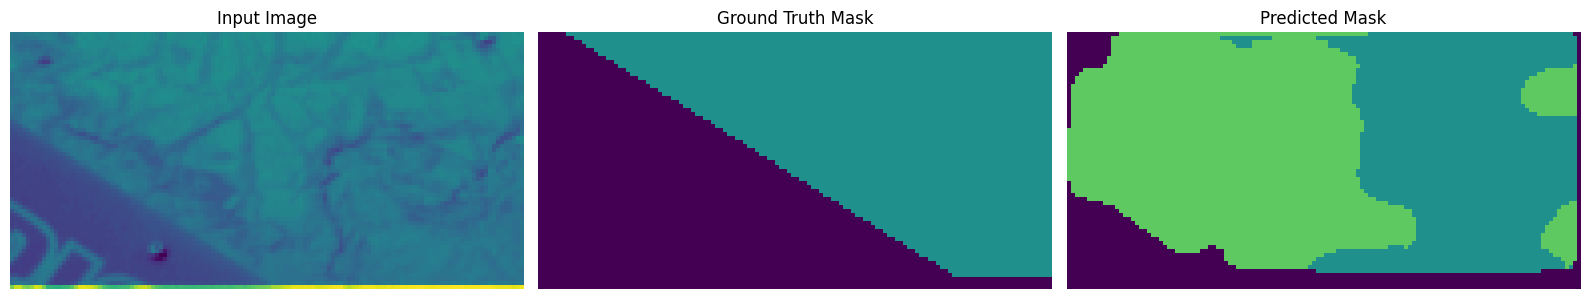

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.7321 - loss: 0.8265 - mean_iou: 0.4366 - val_accuracy: 0.6652 - val_loss: 1.3493 - val_mean_iou: 0.3981
Epoch 17/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7361 - loss: 0.8054 - mean_iou: 0.4405 - val_accuracy: 0.6224 - val_loss: 1.7516 - val_mean_iou: 0.3280
Epoch 18/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7402 - loss: 0.7998 - mean_iou: 0.4446 - val_accuracy: 0.5952 - val_loss: 2.4004 - val_mean_iou: 0.3587
Epoch 19/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.7453 - loss: 0.7897 - mean_iou: 0.4521 - val_accuracy: 0.6761 - val_loss: 1.2256 - val_mean_iou: 0.4028
Epoch 20/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.7441 - loss: 0.7885 - mean_iou: 0.4438 - val_accuracy: 0.7034 - val_loss: 1.1137 - val_mean_iou: 0.4236
Epoch 21/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7588 - loss: 0.7541 - mean_iou: 0.4603

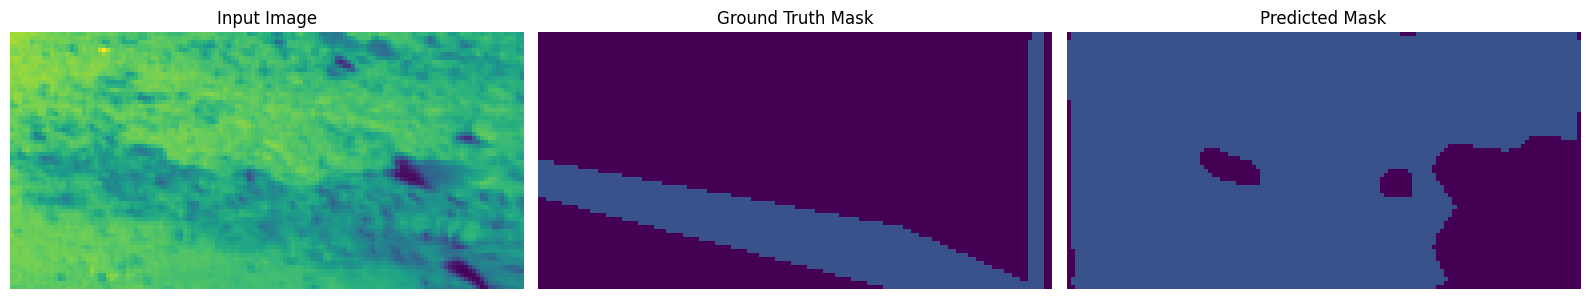

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.7586 - loss: 0.7544 - mean_iou: 0.4602 - val_accuracy: 0.6459 - val_loss: 1.3659 - val_mean_iou: 0.3795
Epoch 22/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7585 - loss: 0.7669 - mean_iou: 0.4565 - val_accuracy: 0.5940 - val_loss: 1.5830 - val_mean_iou: 0.3019
Epoch 23/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7640 - loss: 0.7289 - mean_iou: 0.4602 - val_accuracy: 0.6067 - val_loss: 1.5466 - val_mean_iou: 0.3005
Epoch 24/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.7817 - loss: 0.7128 - mean_iou: 0.4823 - val_accuracy: 0.5609 - val_loss: 1.8007 - val_mean_iou: 0.2657
Epoch 25/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7749 - loss: 0.7142 - mean_iou: 0.4740 - val_accuracy: 0.6003 - val_loss: 1.6380 - val_mean_iou: 0.2953
Epoch 26/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7859 - loss: 0.6779 - mean_iou: 0.4860

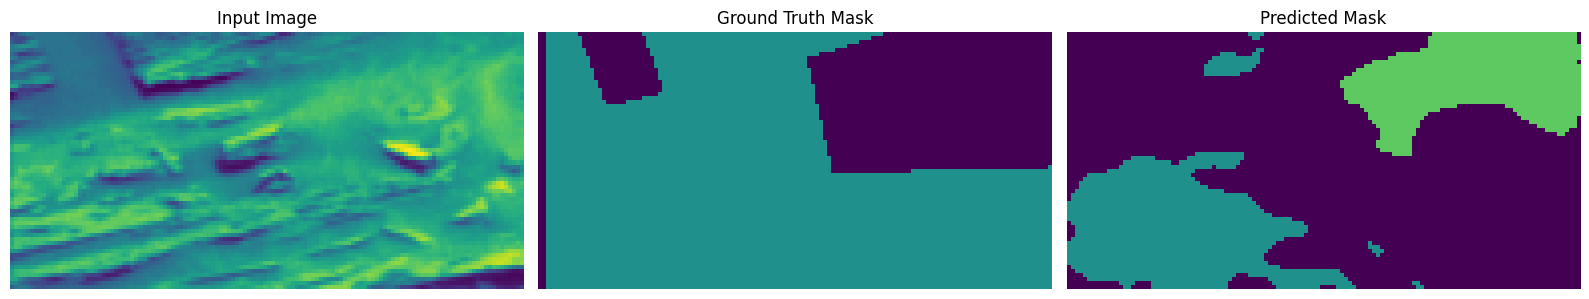

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.7858 - loss: 0.6783 - mean_iou: 0.4859 - val_accuracy: 0.6389 - val_loss: 1.4879 - val_mean_iou: 0.3327
Epoch 27/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7977 - loss: 0.6634 - mean_iou: 0.4943 - val_accuracy: 0.5312 - val_loss: 2.2298 - val_mean_iou: 0.2315
Epoch 28/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7954 - loss: 0.6584 - mean_iou: 0.4914 - val_accuracy: 0.6026 - val_loss: 1.6350 - val_mean_iou: 0.3116
Epoch 29/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7963 - loss: 0.6647 - mean_iou: 0.4866 - val_accuracy: 0.5902 - val_loss: 1.7794 - val_mean_iou: 0.2916
Epoch 30/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7975 - loss: 0.6575 - mean_iou: 0.4893 - val_accuracy: 0.6678 - val_loss: 1.3766 - val_mean_iou: 0.3720
Epoch 31/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8147 - loss: 0.6228 - mean_iou: 0.5045

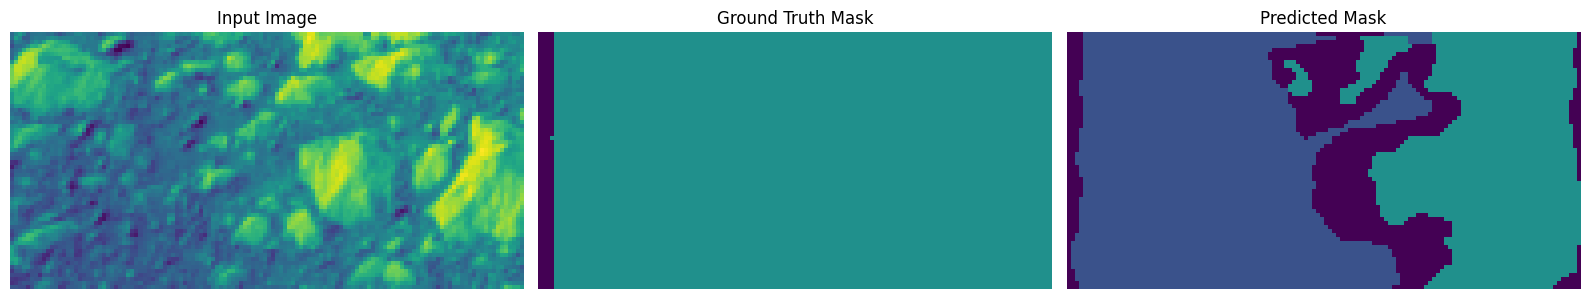

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8144 - loss: 0.6236 - mean_iou: 0.5041 - val_accuracy: 0.6170 - val_loss: 1.4932 - val_mean_iou: 0.3142
Epoch 32/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.8107 - loss: 0.6304 - mean_iou: 0.4992 - val_accuracy: 0.5288 - val_loss: 2.3244 - val_mean_iou: 0.2209
Epoch 33/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.8228 - loss: 0.6161 - mean_iou: 0.5052 - val_accuracy: 0.5607 - val_loss: 1.9253 - val_mean_iou: 0.2642
Epoch 34/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.8188 - loss: 0.6165 - mean_iou: 0.5039 - val_accuracy: 0.5869 - val_loss: 1.8790 - val_mean_iou: 0.2786
Epoch 35/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.8172 - loss: 0.6234 - mean_iou: 0.5016 - val_accuracy: 0.6790 - val_loss: 1.2190 - val_mean_iou: 0.3855
Epoch 36/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8359 - loss: 0.5812 - mean_iou: 0.5131

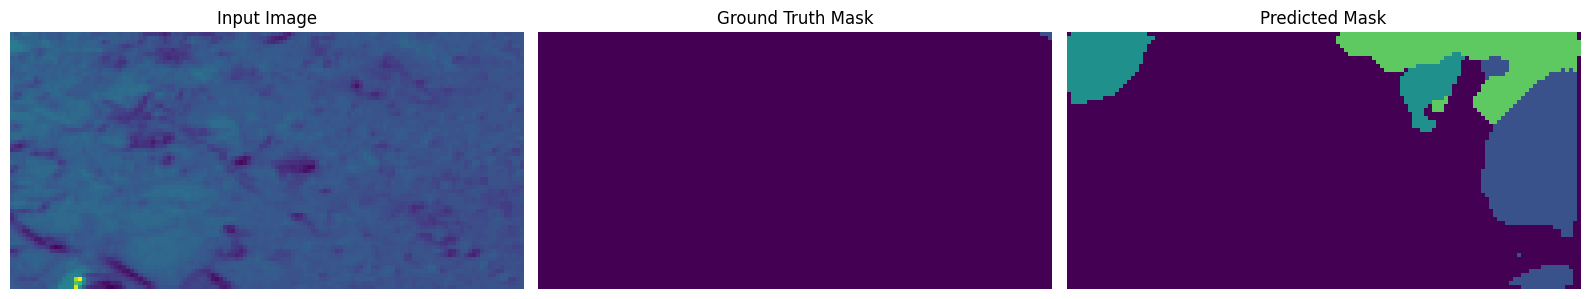

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.8355 - loss: 0.5819 - mean_iou: 0.5128 - val_accuracy: 0.6306 - val_loss: 1.3640 - val_mean_iou: 0.3362
Epoch 37/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8447 - loss: 0.5604 - mean_iou: 0.5189 - val_accuracy: 0.7065 - val_loss: 1.1802 - val_mean_iou: 0.4093
Epoch 38/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.8567 - loss: 0.5312 - mean_iou: 0.5280 - val_accuracy: 0.7084 - val_loss: 1.2022 - val_mean_iou: 0.4305
Epoch 39/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8519 - loss: 0.5530 - mean_iou: 0.5196 - val_accuracy: 0.6386 - val_loss: 1.4467 - val_mean_iou: 0.3546
Epoch 40/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8529 - loss: 0.5492 - mean_iou: 0.5227 - val_accuracy: 0.7001 - val_loss: 1.3921 - val_mean_iou: 0.4145
Epoch 41/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8656 - loss: 0.5116 - mean_iou: 0.5324

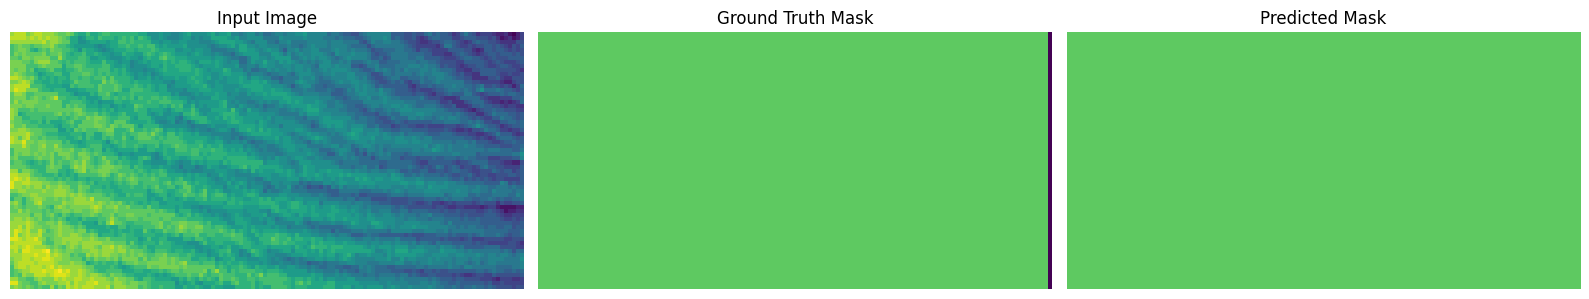

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8652 - loss: 0.5125 - mean_iou: 0.5321 - val_accuracy: 0.6398 - val_loss: 1.5900 - val_mean_iou: 0.3419
Epoch 42/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8621 - loss: 0.5303 - mean_iou: 0.5368 - val_accuracy: 0.6447 - val_loss: 1.3608 - val_mean_iou: 0.3453
Epoch 43/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8613 - loss: 0.5220 - mean_iou: 0.5398 - val_accuracy: 0.7090 - val_loss: 1.3819 - val_mean_iou: 0.4249
Epoch 44/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8634 - loss: 0.5164 - mean_iou: 0.5485 - val_accuracy: 0.6062 - val_loss: 1.6406 - val_mean_iou: 0.3133
Epoch 45/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8588 - loss: 0.5332 - mean_iou: 0.5670 - val_accuracy: 0.6631 - val_loss: 1.3787 - val_mean_iou: 0.3862
Epoch 46/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8717 - loss: 0.5006 - mean_iou: 0.5726

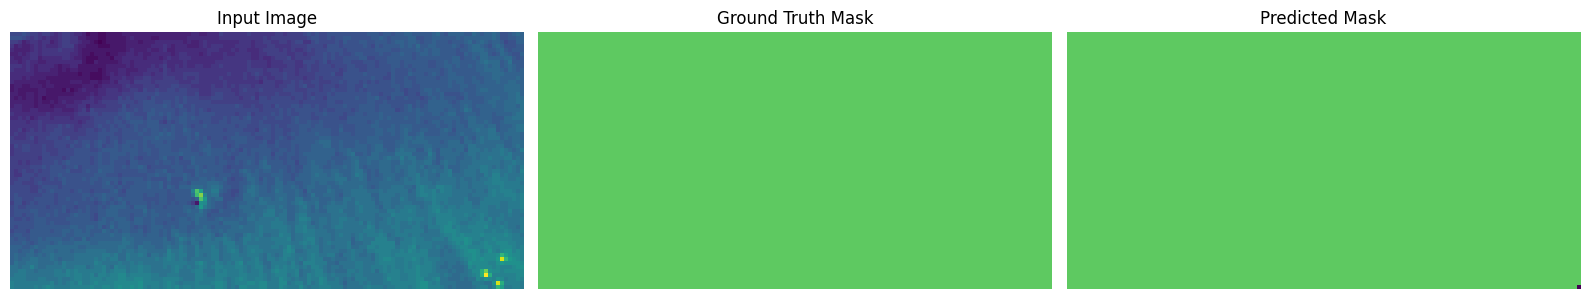

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8713 - loss: 0.5015 - mean_iou: 0.5721 - val_accuracy: 0.6593 - val_loss: 1.3818 - val_mean_iou: 0.3880
Epoch 47/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8807 - loss: 0.4814 - mean_iou: 0.5793 - val_accuracy: 0.6957 - val_loss: 1.2349 - val_mean_iou: 0.4145
Epoch 48/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8809 - loss: 0.4856 - mean_iou: 0.5874 - val_accuracy: 0.6927 - val_loss: 1.2302 - val_mean_iou: 0.4048
Epoch 49/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8895 - loss: 0.4579 - mean_iou: 0.5927 - val_accuracy: 0.6385 - val_loss: 1.4977 - val_mean_iou: 0.3699
Epoch 50/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8879 - loss: 0.4592 - mean_iou: 0.5909 - val_accuracy: 0.5558 - val_loss: 2.3226 - val_mean_iou: 0.2636
Epoch 51/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8875 - loss: 0.4584 - mean_iou: 0.5979

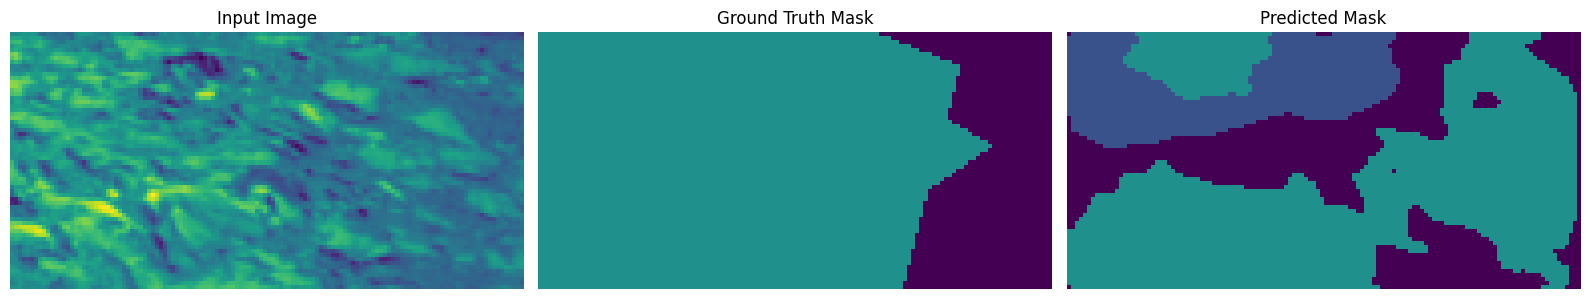

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8871 - loss: 0.4594 - mean_iou: 0.5975 - val_accuracy: 0.6039 - val_loss: 1.6457 - val_mean_iou: 0.3238
Epoch 52/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8899 - loss: 0.4570 - mean_iou: 0.5916 - val_accuracy: 0.6498 - val_loss: 1.6159 - val_mean_iou: 0.3798
Epoch 53/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8882 - loss: 0.4603 - mean_iou: 0.5989 - val_accuracy: 0.7024 - val_loss: 1.2714 - val_mean_iou: 0.4454
Epoch 54/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8924 - loss: 0.4455 - mean_iou: 0.6056 - val_accuracy: 0.6428 - val_loss: 1.3906 - val_mean_iou: 0.3471
Epoch 55/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9006 - loss: 0.4306 - mean_iou: 0.6206 - val_accuracy: 0.6563 - val_loss: 1.4032 - val_mean_iou: 0.3662
Epoch 56/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8994 - loss: 0.4309 - mean_iou: 0.6224

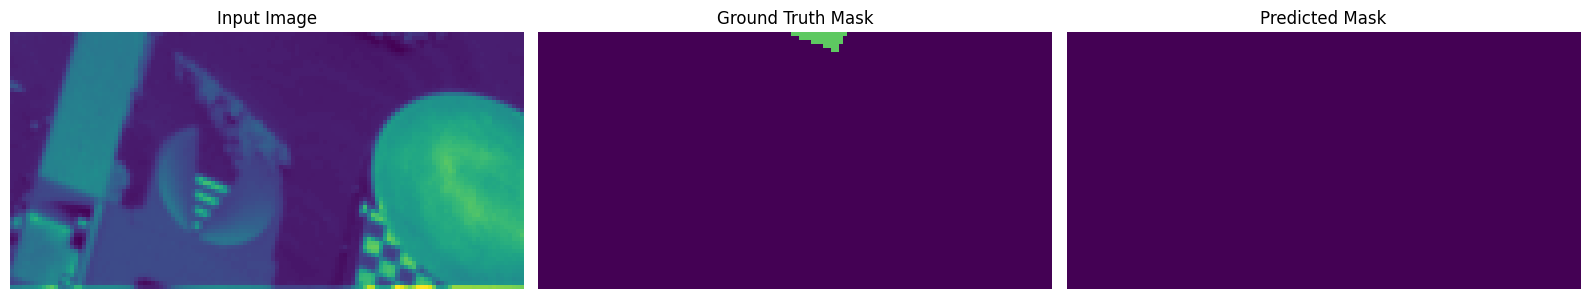

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.8989 - loss: 0.4318 - mean_iou: 0.6217 - val_accuracy: 0.6807 - val_loss: 1.3620 - val_mean_iou: 0.3978
Epoch 57/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9016 - loss: 0.4254 - mean_iou: 0.6230 - val_accuracy: 0.6825 - val_loss: 1.4473 - val_mean_iou: 0.3914
Epoch 58/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8955 - loss: 0.4371 - mean_iou: 0.6174 - val_accuracy: 0.6847 - val_loss: 1.3196 - val_mean_iou: 0.4151
Epoch 59/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8998 - loss: 0.4291 - mean_iou: 0.6147 - val_accuracy: 0.6426 - val_loss: 1.4459 - val_mean_iou: 0.3466
Epoch 60/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9023 - loss: 0.4230 - mean_iou: 0.6211 - val_accuracy: 0.6814 - val_loss: 1.3597 - val_mean_iou: 0.4030
Epoch 61/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9085 - loss: 0.4074 - mean_iou: 0.6348

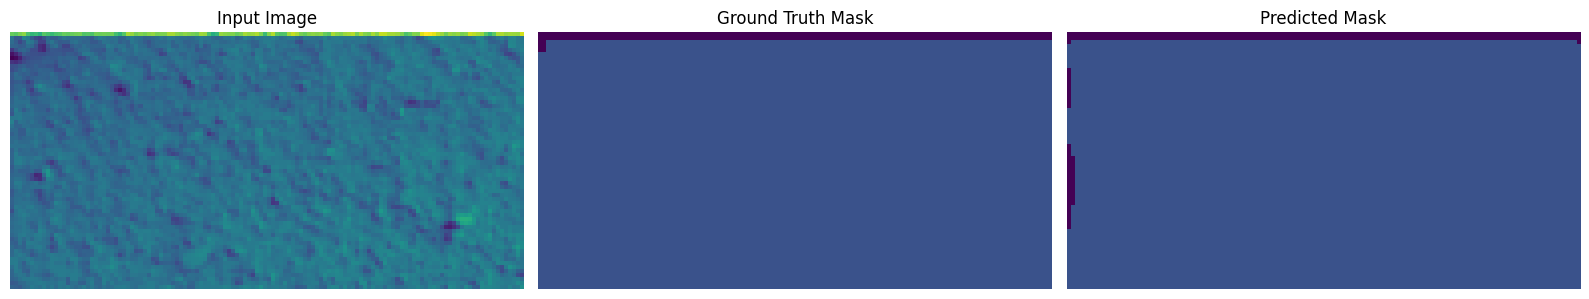

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9080 - loss: 0.4085 - mean_iou: 0.6343 - val_accuracy: 0.7049 - val_loss: 1.1923 - val_mean_iou: 0.4381
Epoch 62/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9121 - loss: 0.4041 - mean_iou: 0.6367 - val_accuracy: 0.6860 - val_loss: 1.2706 - val_mean_iou: 0.4313
Epoch 63/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9089 - loss: 0.4031 - mean_iou: 0.6416 - val_accuracy: 0.6971 - val_loss: 1.3012 - val_mean_iou: 0.4111
Epoch 64/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9132 - loss: 0.3925 - mean_iou: 0.6393 - val_accuracy: 0.6516 - val_loss: 1.4401 - val_mean_iou: 0.3475
Epoch 65/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9109 - loss: 0.4015 - mean_iou: 0.6378 - val_accuracy: 0.7056 - val_loss: 1.3242 - val_mean_iou: 0.4280
Epoch 66/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9149 - loss: 0.3911 - mean_iou: 0.6510

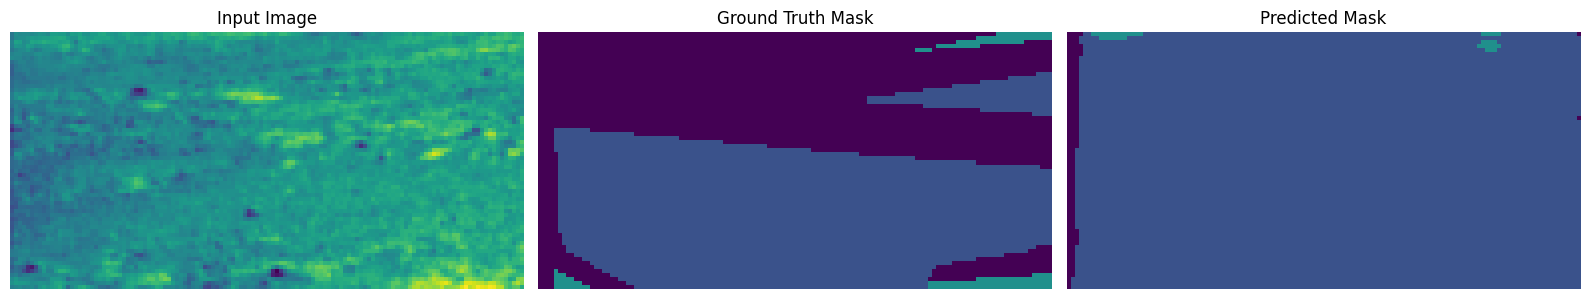

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9144 - loss: 0.3922 - mean_iou: 0.6503 - val_accuracy: 0.7084 - val_loss: 1.2772 - val_mean_iou: 0.4327
Epoch 67/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9168 - loss: 0.3849 - mean_iou: 0.6440 - val_accuracy: 0.7071 - val_loss: 1.2831 - val_mean_iou: 0.4438
Epoch 68/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9166 - loss: 0.3796 - mean_iou: 0.6501 - val_accuracy: 0.6655 - val_loss: 1.2926 - val_mean_iou: 0.4051
Epoch 69/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9112 - loss: 0.3942 - mean_iou: 0.6425 - val_accuracy: 0.6929 - val_loss: 1.3097 - val_mean_iou: 0.4306
Epoch 70/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9186 - loss: 0.3789 - mean_iou: 0.6552 - val_accuracy: 0.7034 - val_loss: 1.3082 - val_mean_iou: 0.4403
Epoch 71/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9107 - loss: 0.3974 - mean_iou: 0.6571

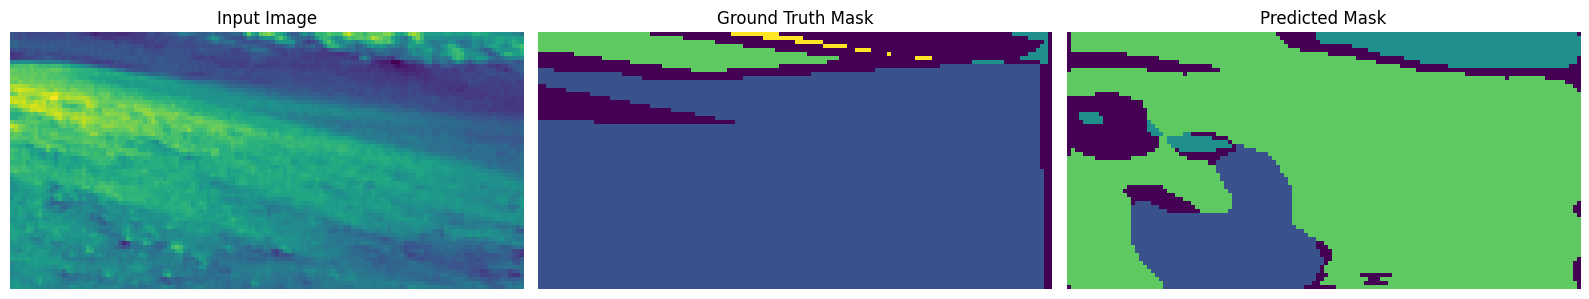

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9103 - loss: 0.3984 - mean_iou: 0.6563 - val_accuracy: 0.6857 - val_loss: 1.2673 - val_mean_iou: 0.4137
Epoch 72/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9147 - loss: 0.3859 - mean_iou: 0.6610 - val_accuracy: 0.6348 - val_loss: 1.5989 - val_mean_iou: 0.3457
Epoch 73/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9185 - loss: 0.3799 - mean_iou: 0.6567 - val_accuracy: 0.7085 - val_loss: 1.2285 - val_mean_iou: 0.4406
Epoch 74/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9217 - loss: 0.3678 - mean_iou: 0.6679 - val_accuracy: 0.6500 - val_loss: 1.5293 - val_mean_iou: 0.3599
Epoch 75/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9198 - loss: 0.3706 - mean_iou: 0.6677 - val_accuracy: 0.7036 - val_loss: 1.2225 - val_mean_iou: 0.4241
Epoch 76/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9208 - loss: 0.3695 - mean_iou: 0.6557

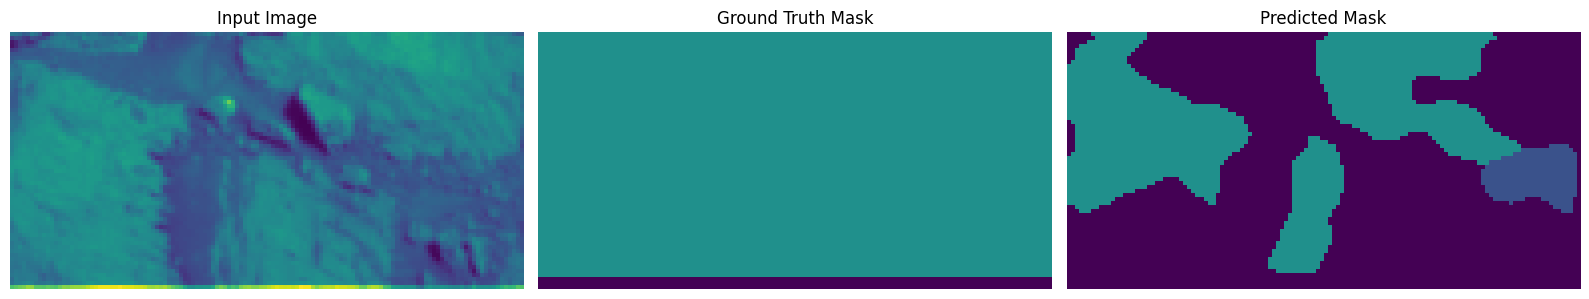

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9204 - loss: 0.3706 - mean_iou: 0.6549 - val_accuracy: 0.7115 - val_loss: 1.1960 - val_mean_iou: 0.4455
Epoch 77/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9208 - loss: 0.3738 - mean_iou: 0.6674 - val_accuracy: 0.6922 - val_loss: 1.3175 - val_mean_iou: 0.4252
Epoch 78/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9263 - loss: 0.3544 - mean_iou: 0.6697 - val_accuracy: 0.6959 - val_loss: 1.1925 - val_mean_iou: 0.4084
Epoch 79/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9297 - loss: 0.3473 - mean_iou: 0.6724 - val_accuracy: 0.6972 - val_loss: 1.3097 - val_mean_iou: 0.4296
Epoch 80/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9257 - loss: 0.3501 - mean_iou: 0.6697 - val_accuracy: 0.6746 - val_loss: 1.4019 - val_mean_iou: 0.3840
Epoch 81/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9298 - loss: 0.3456 - mean_iou: 0.6719

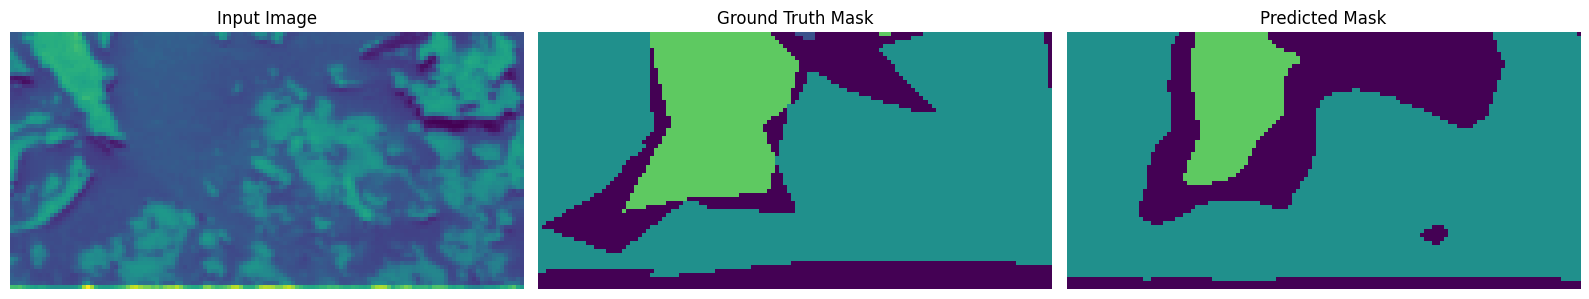

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9293 - loss: 0.3468 - mean_iou: 0.6712 - val_accuracy: 0.7266 - val_loss: 1.1942 - val_mean_iou: 0.4725
Epoch 82/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9293 - loss: 0.3449 - mean_iou: 0.6845 - val_accuracy: 0.6978 - val_loss: 1.3119 - val_mean_iou: 0.4329
Epoch 83/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9234 - loss: 0.3632 - mean_iou: 0.6713 - val_accuracy: 0.7284 - val_loss: 1.2039 - val_mean_iou: 0.4626
Epoch 84/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9337 - loss: 0.3340 - mean_iou: 0.6761 - val_accuracy: 0.6678 - val_loss: 1.4748 - val_mean_iou: 0.3796
Epoch 85/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9330 - loss: 0.3330 - mean_iou: 0.6828 - val_accuracy: 0.7276 - val_loss: 1.2962 - val_mean_iou: 0.4688
Epoch 86/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9335 - loss: 0.3320 - mean_iou: 0.6853

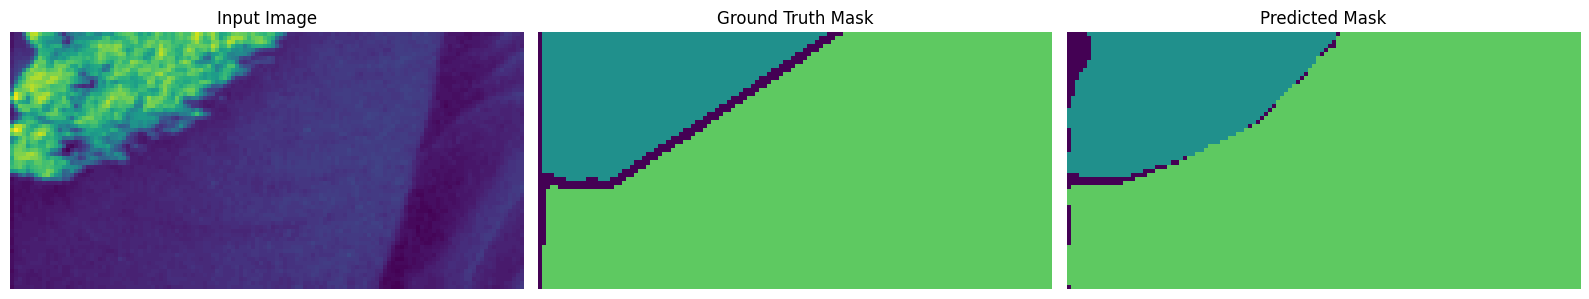

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9330 - loss: 0.3330 - mean_iou: 0.6847 - val_accuracy: 0.7154 - val_loss: 1.3665 - val_mean_iou: 0.4344
Epoch 87/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9323 - loss: 0.3345 - mean_iou: 0.6912 - val_accuracy: 0.7060 - val_loss: 1.3138 - val_mean_iou: 0.4524
Epoch 88/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9236 - loss: 0.3563 - mean_iou: 0.6663 - val_accuracy: 0.7133 - val_loss: 1.3717 - val_mean_iou: 0.4366
Epoch 89/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9277 - loss: 0.3501 - mean_iou: 0.6793 - val_accuracy: 0.6922 - val_loss: 1.3659 - val_mean_iou: 0.4141
Epoch 90/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9348 - loss: 0.3295 - mean_iou: 0.6940 - val_accuracy: 0.7038 - val_loss: 1.3609 - val_mean_iou: 0.4164
Epoch 91/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9342 - loss: 0.3354 - mean_iou: 0.6852

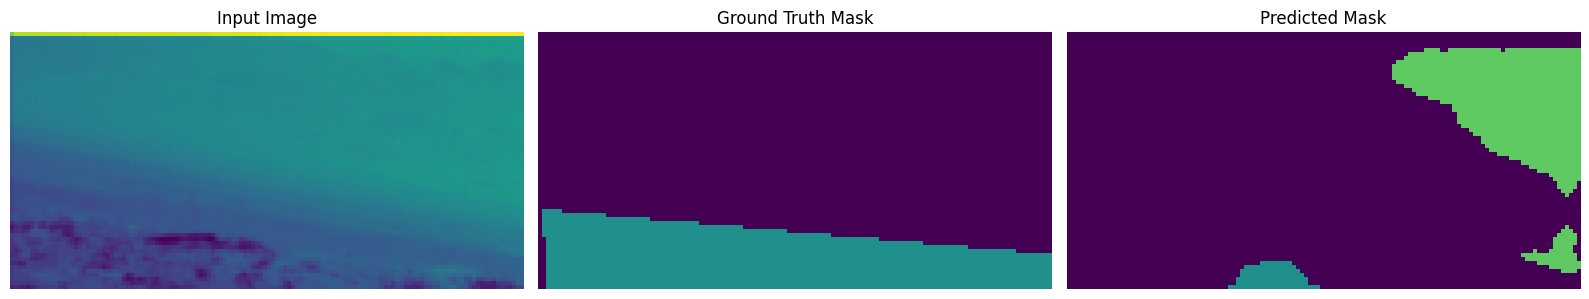

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9338 - loss: 0.3366 - mean_iou: 0.6847 - val_accuracy: 0.7112 - val_loss: 1.1851 - val_mean_iou: 0.4386
Epoch 92/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9373 - loss: 0.3261 - mean_iou: 0.6911 - val_accuracy: 0.7062 - val_loss: 1.2714 - val_mean_iou: 0.4623
Epoch 93/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9302 - loss: 0.3401 - mean_iou: 0.6749 - val_accuracy: 0.7047 - val_loss: 1.2223 - val_mean_iou: 0.4355
Epoch 94/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9383 - loss: 0.3170 - mean_iou: 0.6925 - val_accuracy: 0.7182 - val_loss: 1.3929 - val_mean_iou: 0.4551
Epoch 95/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9385 - loss: 0.3185 - mean_iou: 0.6973 - val_accuracy: 0.6958 - val_loss: 1.6701 - val_mean_iou: 0.4317
Epoch 96/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9292 - loss: 0.3476 - mean_iou: 0.6704

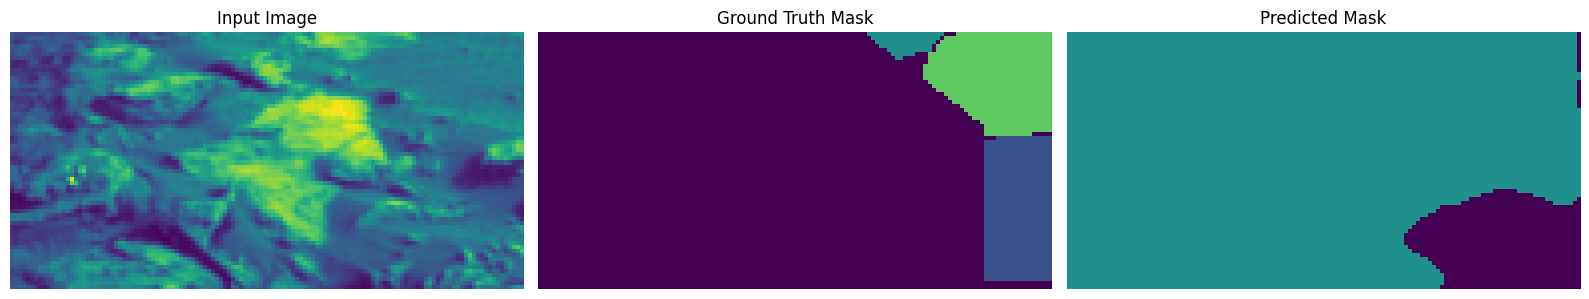

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9287 - loss: 0.3489 - mean_iou: 0.6697 - val_accuracy: 0.6920 - val_loss: 1.3523 - val_mean_iou: 0.4493
Epoch 97/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9337 - loss: 0.3351 - mean_iou: 0.6951 - val_accuracy: 0.7089 - val_loss: 1.2236 - val_mean_iou: 0.4516
Epoch 98/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9397 - loss: 0.3162 - mean_iou: 0.6991 - val_accuracy: 0.7287 - val_loss: 1.2680 - val_mean_iou: 0.4614
Epoch 99/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9379 - loss: 0.3181 - mean_iou: 0.7084 - val_accuracy: 0.7179 - val_loss: 1.1596 - val_mean_iou: 0.4470
Epoch 100/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9389 - loss: 0.3208 - mean_iou: 0.6936 - val_accuracy: 0.6679 - val_loss: 1.4588 - val_mean_iou: 0.4016
Epoch 101/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9383 - loss: 0.3207 - mean_iou: 0.7016

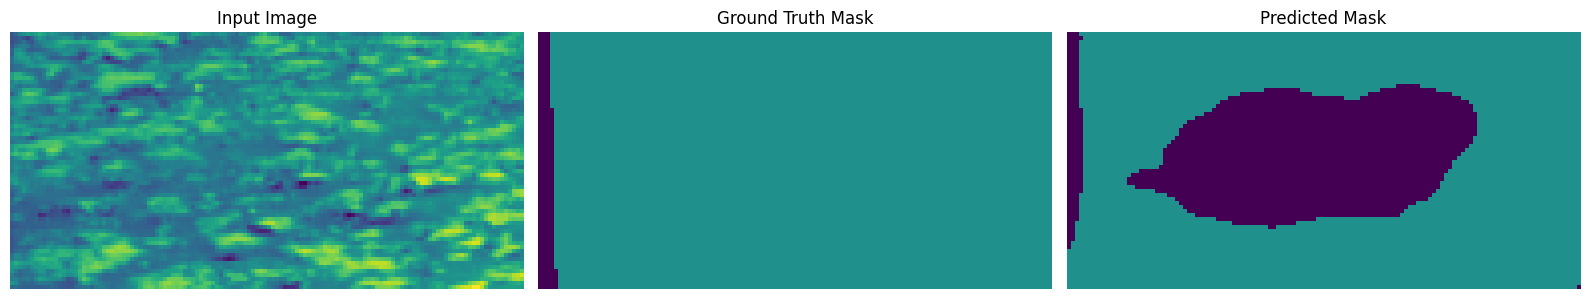

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9379 - loss: 0.3219 - mean_iou: 0.7010 - val_accuracy: 0.6869 - val_loss: 1.2319 - val_mean_iou: 0.4262
Epoch 102/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9277 - loss: 0.3446 - mean_iou: 0.6798 - val_accuracy: 0.6953 - val_loss: 1.4317 - val_mean_iou: 0.4285
Epoch 103/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9363 - loss: 0.3226 - mean_iou: 0.6975 - val_accuracy: 0.6863 - val_loss: 1.5404 - val_mean_iou: 0.4126
Epoch 104/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9395 - loss: 0.3195 - mean_iou: 0.7023 - val_accuracy: 0.7091 - val_loss: 1.3526 - val_mean_iou: 0.4577
Epoch 105/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9436 - loss: 0.3057 - mean_iou: 0.7038 - val_accuracy: 0.7257 - val_loss: 1.1797 - val_mean_iou: 0.4630
Epoch 106/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9437 - loss: 0.3035 - mean_iou: 0.7093

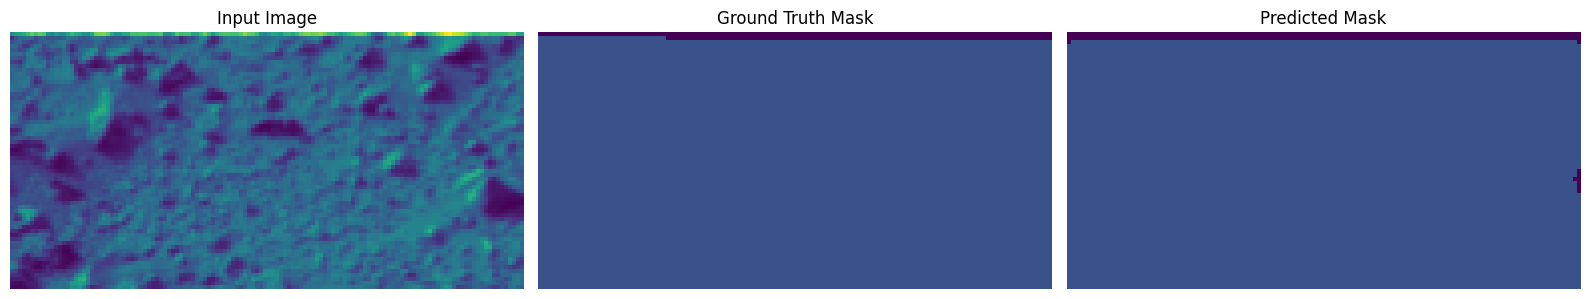

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9433 - loss: 0.3046 - mean_iou: 0.7085 - val_accuracy: 0.6855 - val_loss: 1.2907 - val_mean_iou: 0.4023
Epoch 107/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9436 - loss: 0.3045 - mean_iou: 0.7191 - val_accuracy: 0.6740 - val_loss: 1.2555 - val_mean_iou: 0.3853
Epoch 108/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9418 - loss: 0.3113 - mean_iou: 0.6958 - val_accuracy: 0.7071 - val_loss: 1.2404 - val_mean_iou: 0.4310
Epoch 109/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9412 - loss: 0.3096 - mean_iou: 0.6921 - val_accuracy: 0.7275 - val_loss: 1.1980 - val_mean_iou: 0.4732
Epoch 110/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9439 - loss: 0.3044 - mean_iou: 0.7070 - val_accuracy: 0.7268 - val_loss: 1.2130 - val_mean_iou: 0.4633
Epoch 111/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9443 - loss: 0.3016 - mean_iou: 0.7076

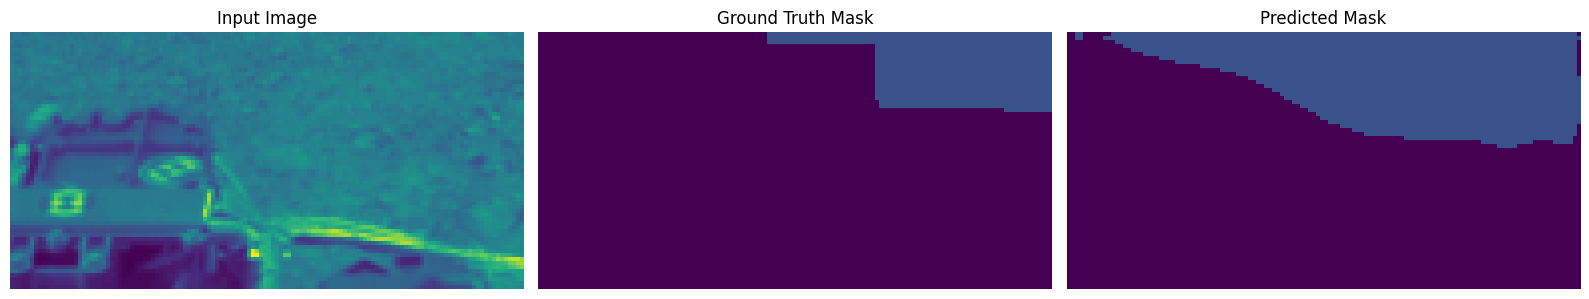

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9439 - loss: 0.3026 - mean_iou: 0.7072 - val_accuracy: 0.7128 - val_loss: 1.4329 - val_mean_iou: 0.4492
Epoch 112/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9455 - loss: 0.2996 - mean_iou: 0.7100 - val_accuracy: 0.7055 - val_loss: 1.3066 - val_mean_iou: 0.4355
Epoch 113/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9457 - loss: 0.3007 - mean_iou: 0.7092 - val_accuracy: 0.7427 - val_loss: 1.1783 - val_mean_iou: 0.4852
Epoch 114/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9479 - loss: 0.2920 - mean_iou: 0.7060 - val_accuracy: 0.7342 - val_loss: 1.1391 - val_mean_iou: 0.4537
Epoch 115/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9477 - loss: 0.2949 - mean_iou: 0.7184 - val_accuracy: 0.7187 - val_loss: 1.2411 - val_mean_iou: 0.4522
Epoch 116/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9476 - loss: 0.2938 - mean_iou: 0.7170

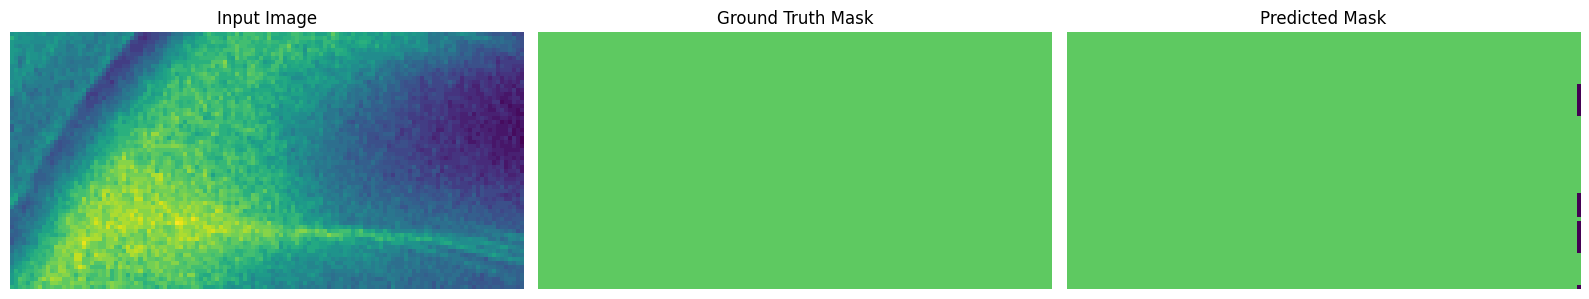

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9471 - loss: 0.2950 - mean_iou: 0.7163 - val_accuracy: 0.7144 - val_loss: 1.4351 - val_mean_iou: 0.4335
Epoch 117/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9400 - loss: 0.3136 - mean_iou: 0.7002 - val_accuracy: 0.7187 - val_loss: 1.3726 - val_mean_iou: 0.4430
Epoch 118/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9473 - loss: 0.2940 - mean_iou: 0.7184 - val_accuracy: 0.7279 - val_loss: 1.2586 - val_mean_iou: 0.4671
Epoch 119/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9493 - loss: 0.2901 - mean_iou: 0.7209 - val_accuracy: 0.6984 - val_loss: 1.2452 - val_mean_iou: 0.4403
Epoch 120/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9475 - loss: 0.2935 - mean_iou: 0.7185 - val_accuracy: 0.7371 - val_loss: 1.1387 - val_mean_iou: 0.4769
Epoch 121/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9487 - loss: 0.2922 - mean_iou: 0.7195

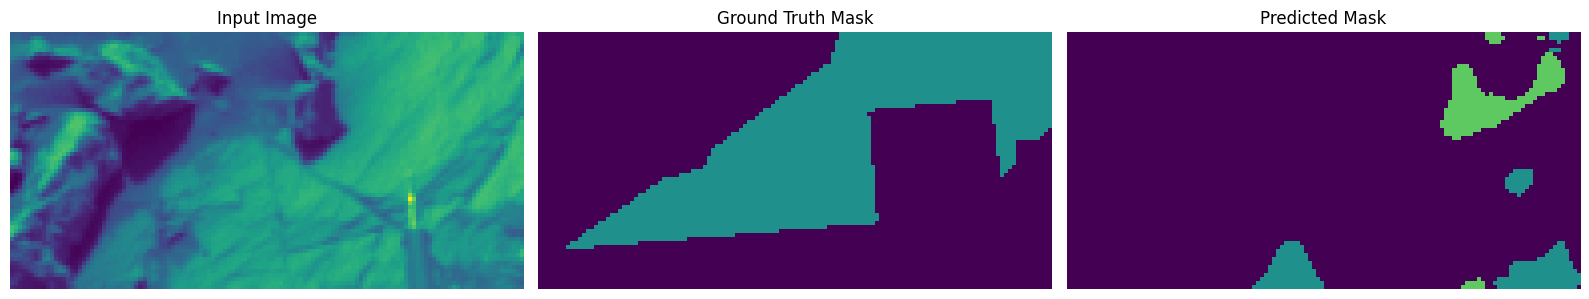

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9483 - loss: 0.2934 - mean_iou: 0.7188 - val_accuracy: 0.7051 - val_loss: 1.2680 - val_mean_iou: 0.4371
Epoch 122/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9483 - loss: 0.2910 - mean_iou: 0.7173 - val_accuracy: 0.7063 - val_loss: 1.2623 - val_mean_iou: 0.4388
Epoch 123/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9510 - loss: 0.2869 - mean_iou: 0.7248 - val_accuracy: 0.7246 - val_loss: 1.1578 - val_mean_iou: 0.4675
Epoch 124/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9486 - loss: 0.2866 - mean_iou: 0.7160 - val_accuracy: 0.6926 - val_loss: 1.4396 - val_mean_iou: 0.4248
Epoch 125/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9484 - loss: 0.2933 - mean_iou: 0.7153 - val_accuracy: 0.7220 - val_loss: 1.1680 - val_mean_iou: 0.4447
Epoch 126/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9496 - loss: 0.2885 - mean_iou: 0.7226

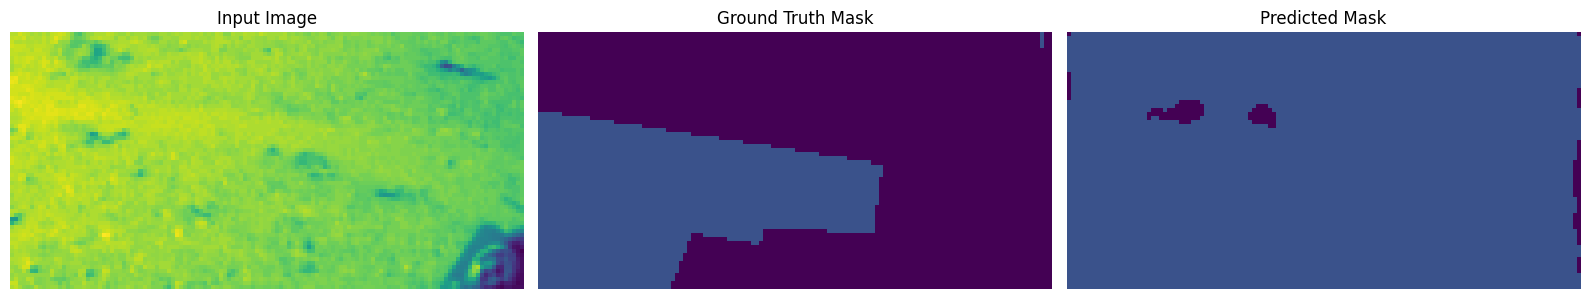

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9491 - loss: 0.2897 - mean_iou: 0.7220 - val_accuracy: 0.6288 - val_loss: 1.8880 - val_mean_iou: 0.3578
Epoch 127/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9473 - loss: 0.2943 - mean_iou: 0.7195 - val_accuracy: 0.7112 - val_loss: 1.3305 - val_mean_iou: 0.4553
Epoch 128/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9488 - loss: 0.2910 - mean_iou: 0.7148 - val_accuracy: 0.7260 - val_loss: 1.3274 - val_mean_iou: 0.4553
Epoch 129/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9486 - loss: 0.2909 - mean_iou: 0.7188 - val_accuracy: 0.7252 - val_loss: 1.1757 - val_mean_iou: 0.4644
Epoch 130/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9470 - loss: 0.2978 - mean_iou: 0.7145 - val_accuracy: 0.7305 - val_loss: 1.1800 - val_mean_iou: 0.4844
Epoch 131/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9498 - loss: 0.2877 - mean_iou: 0.7137

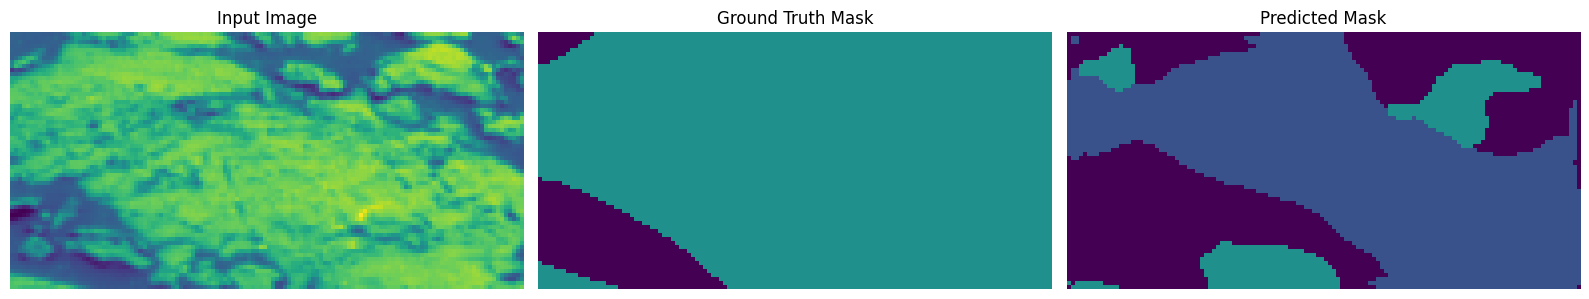

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9494 - loss: 0.2887 - mean_iou: 0.7131 - val_accuracy: 0.6899 - val_loss: 1.4593 - val_mean_iou: 0.4083
Epoch 132/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9531 - loss: 0.2800 - mean_iou: 0.7247 - val_accuracy: 0.6774 - val_loss: 1.4166 - val_mean_iou: 0.4068
Epoch 133/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9524 - loss: 0.2799 - mean_iou: 0.7192 - val_accuracy: 0.6745 - val_loss: 1.3810 - val_mean_iou: 0.4086
Epoch 134/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9531 - loss: 0.2788 - mean_iou: 0.7170 - val_accuracy: 0.7005 - val_loss: 1.2686 - val_mean_iou: 0.4281
Epoch 135/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9504 - loss: 0.2856 - mean_iou: 0.7223 - val_accuracy: 0.7034 - val_loss: 1.3796 - val_mean_iou: 0.4569
Epoch 136/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9518 - loss: 0.2811 - mean_iou: 0.7263

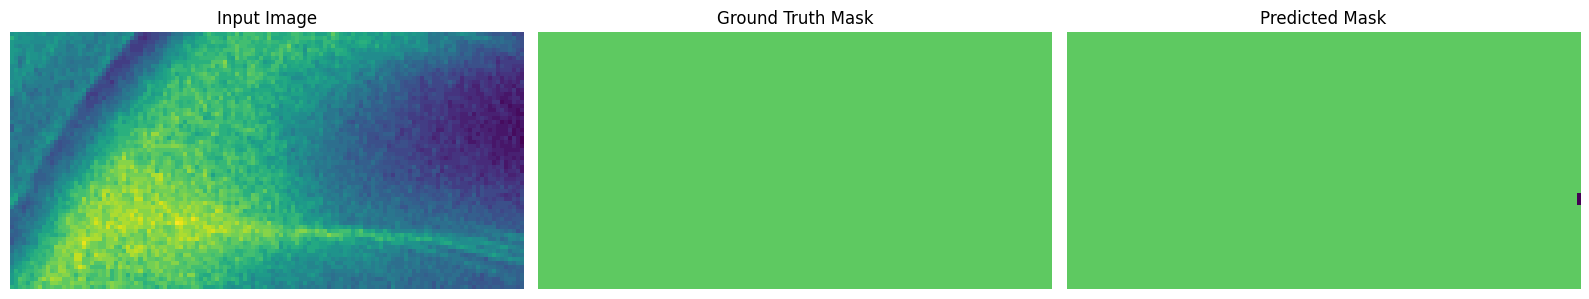

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.9514 - loss: 0.2821 - mean_iou: 0.7256 - val_accuracy: 0.7222 - val_loss: 1.1637 - val_mean_iou: 0.4590
Epoch 137/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9543 - loss: 0.2756 - mean_iou: 0.7236 - val_accuracy: 0.7199 - val_loss: 1.2595 - val_mean_iou: 0.4418
Epoch 138/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9464 - loss: 0.2989 - mean_iou: 0.7201 - val_accuracy: 0.7114 - val_loss: 1.2886 - val_mean_iou: 0.4409
Epoch 139/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9508 - loss: 0.2864 - mean_iou: 0.7258 - val_accuracy: 0.7333 - val_loss: 1.2683 - val_mean_iou: 0.4704
Epoch 140/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9549 - loss: 0.2754 - mean_iou: 0.7285 - val_accuracy: 0.7299 - val_loss: 1.2697 - val_mean_iou: 0.4581
Epoch 141/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9538 - loss: 0.2777 - mean_iou: 0.7326

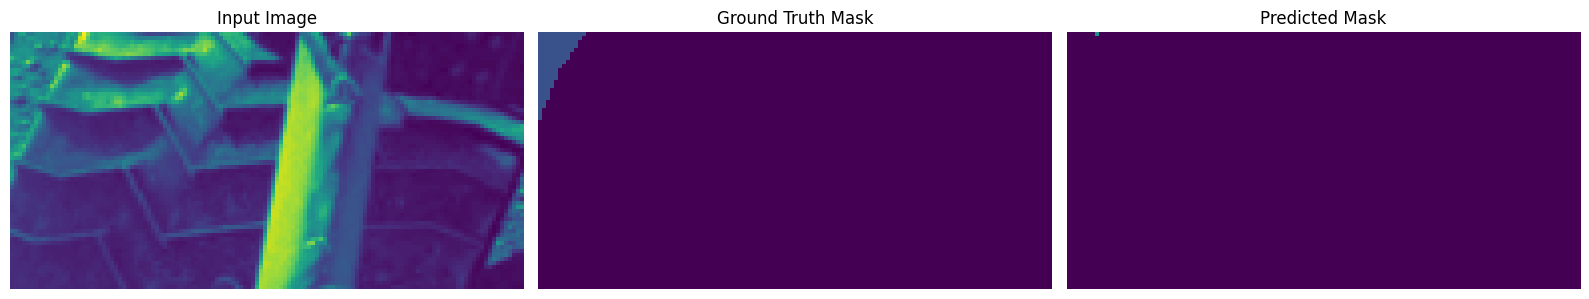

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9533 - loss: 0.2788 - mean_iou: 0.7318 - val_accuracy: 0.7251 - val_loss: 1.3987 - val_mean_iou: 0.4487
Epoch 142/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9509 - loss: 0.2868 - mean_iou: 0.7153 - val_accuracy: 0.7088 - val_loss: 1.3177 - val_mean_iou: 0.4509
Epoch 143/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9525 - loss: 0.2802 - mean_iou: 0.7344 - val_accuracy: 0.7272 - val_loss: 1.2525 - val_mean_iou: 0.4739
Epoch 144/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9476 - loss: 0.2948 - mean_iou: 0.7225 - val_accuracy: 0.6962 - val_loss: 1.3868 - val_mean_iou: 0.4481
Epoch 145/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9533 - loss: 0.2788 - mean_iou: 0.7296 - val_accuracy: 0.7369 - val_loss: 1.1604 - val_mean_iou: 0.4709
Epoch 146/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9562 - loss: 0.2703 - mean_iou: 0.7401

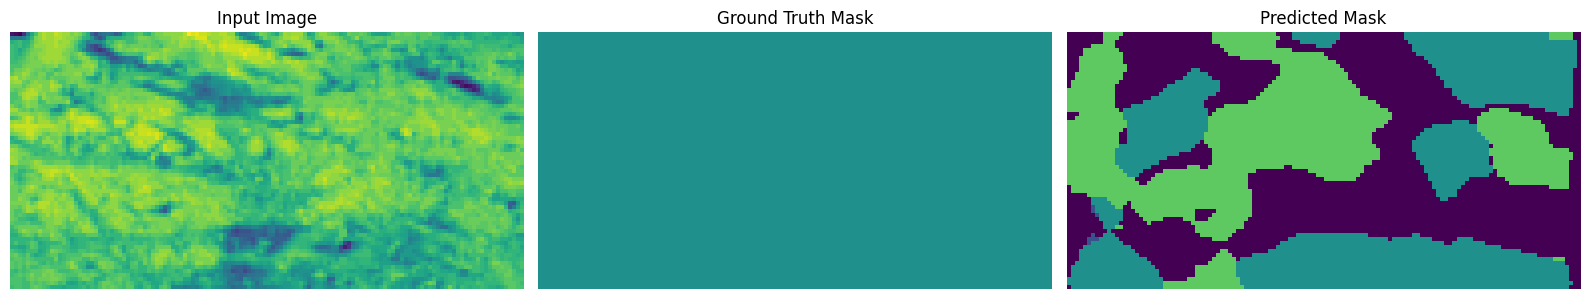

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9558 - loss: 0.2714 - mean_iou: 0.7394 - val_accuracy: 0.7214 - val_loss: 1.3800 - val_mean_iou: 0.4397
Epoch 147/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9532 - loss: 0.2786 - mean_iou: 0.7346 - val_accuracy: 0.7344 - val_loss: 1.2066 - val_mean_iou: 0.4649
Epoch 148/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9560 - loss: 0.2699 - mean_iou: 0.7252 - val_accuracy: 0.7296 - val_loss: 1.1917 - val_mean_iou: 0.4698
Epoch 149/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.9532 - loss: 0.2806 - mean_iou: 0.7314 - val_accuracy: 0.7103 - val_loss: 1.1584 - val_mean_iou: 0.4317
Epoch 150/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.9547 - loss: 0.2735 - mean_iou: 0.7270 - val_accuracy: 0.7398 - val_loss: 1.2631 - val_mean_iou: 0.4687
Epoch 151/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9537 - loss: 0.2780 - mean_iou: 0.7145

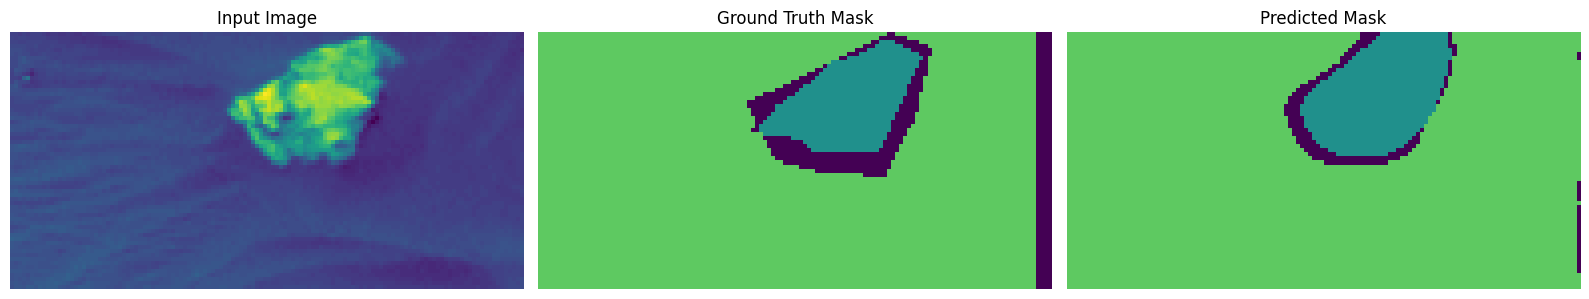

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9533 - loss: 0.2790 - mean_iou: 0.7140 - val_accuracy: 0.7349 - val_loss: 1.2785 - val_mean_iou: 0.4743
Epoch 152/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.9549 - loss: 0.2756 - mean_iou: 0.7231 - val_accuracy: 0.7337 - val_loss: 1.1928 - val_mean_iou: 0.4735
Epoch 153/1000
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.9572 - loss: 0.2705 - mean_iou: 0.7368 - val_accuracy: 0.7356 - val_loss: 1.2860 - val_mean_iou: 0.4662


In [ ]:
history = model.fit(
    final_dataset,
    epochs=epoch,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
#final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
#print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')


# Definisci il percorso di salvataggio nella directory di lavoro
model.save("/kaggle/working/Tentativo6.keras")

print("FINITO")
# Delete the model to free up resources
del model

# Save and testing

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

X_test = np.load("/kaggle/input/datasetlomi/test_set.npz")

get_custom_objects()['CombinedLoss'] = CombinedLoss

model_filename = "Tentativo6.keras"
model = tf.keras.models.load_model(
    "/kaggle/working/Tentativo6.keras",
    custom_objects={'CombinedLoss': CombinedLoss}
)

preds = model.predict(X_test["images"]/255)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)